# Tottenham Hotspur 2024/25 Season Attacking Player Analysis (Matchweek 1-32 (All Competitions)) - April 15th 2025
# Author: Ezekiel Loty

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from sklearn.decomposition import PCA

plt.style.use('fivethirtyeight')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 8)

df = pd.read_csv('csv-files/player.csv')

print(f"Dataset shape: {df.shape}")
df.head()

print("\nMissing values per column:")
print(df.isna().sum())

attacking_players = df[
    (df['Pos'].str.contains('FW')) | 
    (df['Pos'].str.contains('MF') & 
     ((df['Gls'] >= 2) | (df['Ast'] >= 2) | (df['xG'] >= 2)))
].copy() 

print(f"\nNumber of attacking players identified: {len(attacking_players)}")
print(attacking_players[['Player', 'Pos', 'Age', '90s', 'Gls', 'Ast', 'xG', 'xA']].sort_values(by='90s', ascending=False))

attacking_players['Gls_per90'] = attacking_players['Gls'] / attacking_players['90s']
attacking_players['Ast_per90'] = attacking_players['Ast'] / attacking_players['90s']
attacking_players['xG_per90'] = attacking_players['xG'] / attacking_players['90s']
attacking_players['xA_per90'] = attacking_players['xA'] / attacking_players['90s']
attacking_players['GA_per90'] = attacking_players['Gls_per90'] + attacking_players['Ast_per90']
attacking_players['xGA_per90'] = attacking_players['xG_per90'] + attacking_players['xA_per90']

attacking_players['Shot_conversion'] = attacking_players['Gls'] / attacking_players['Sh'] * 100
attacking_players['xG_overperformance'] = attacking_players['Gls'] - attacking_players['xG']

Dataset shape: (26, 83)

Missing values per column:
Player               0
Nation               0
Pos                  0
Age                  0
90s                  0
                    ..
GCA_TypesPassDead    0
GCA_TypesTO          0
GCA_TypesSh          0
GCA_TypesFld         0
GCA_TypesDef         0
Length: 83, dtype: int64

Number of attacking players identified: 14
               Player    Pos    Age   90s  Gls  Ast    xG   xA
1    Dejan Kulusevski  MF,FW  24.96  33.9   10   10   4.6  5.1
2       Son Heung-min     FW  32.76  33.0   11   11   9.4  6.2
4     Dominic Solanke     FW  27.57  30.1   11    8  12.3  1.5
5     Brennan Johnson     FW  23.88  29.0   16    3  11.3  2.9
6      James Maddison     MF  28.38  26.6   11    8   7.0  7.3
7     Pape Matar Sarr     MF  22.57  25.9    6    2   3.9  1.0
8   Rodrigo Bentancur     MF  27.79  25.2    2    1   1.4  1.5
12     Lucas Bergvall     MF  19.18  22.5    1    2   1.3  1.3
13      Yves Bissouma     MF  28.61  22.1    2    0   0.6  

# Exploratory visualizations

# 1. Goal contributions per 90

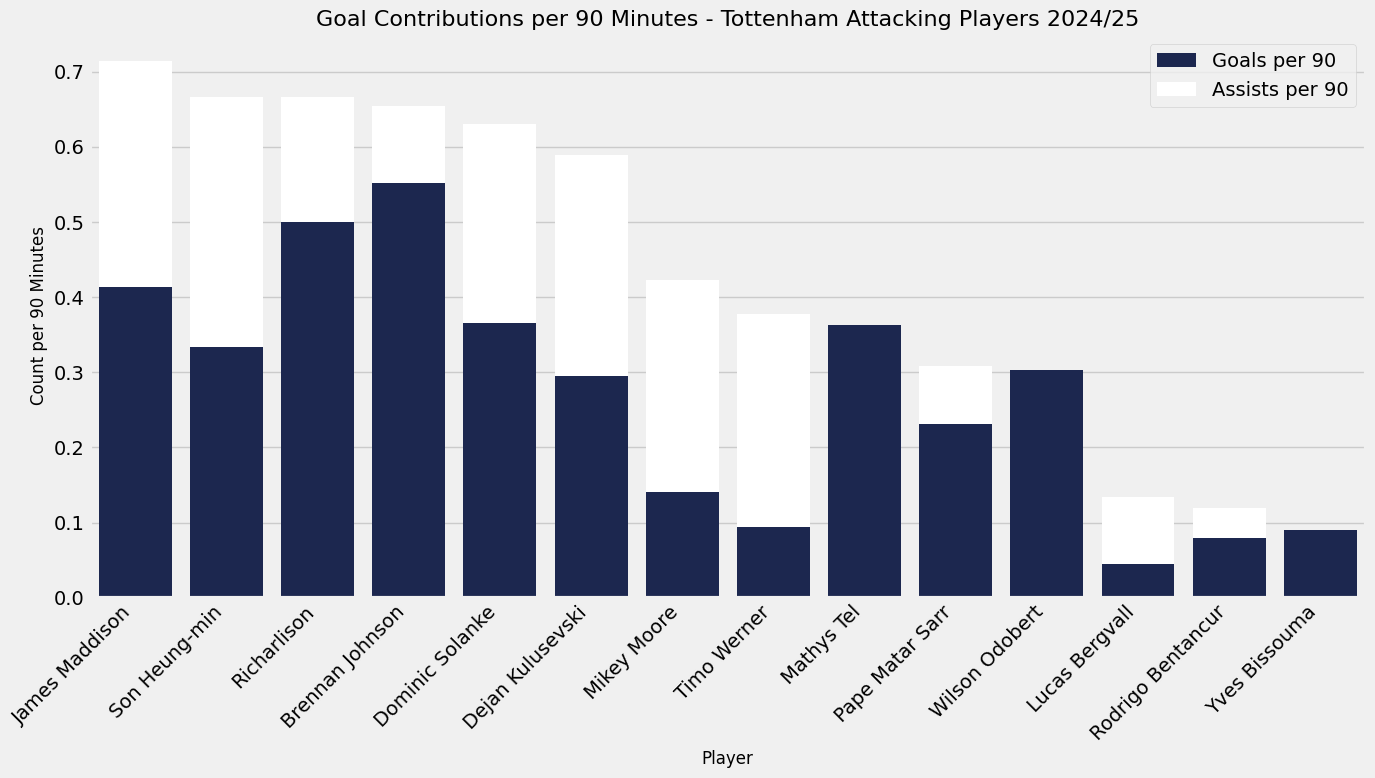

In [12]:
plt.figure(figsize=(14, 8))
players = attacking_players.sort_values('GA_per90', ascending=False)['Player']
goals = attacking_players.sort_values('GA_per90', ascending=False)['Gls_per90']
assists = attacking_players.sort_values('GA_per90', ascending=False)['Ast_per90']

ax = sns.barplot(x=players, y=goals, color='#132257', label='Goals per 90')
sns.barplot(x=players, y=assists, color='#ffffff', bottom=goals, label='Assists per 90')

plt.title('Goal Contributions per 90 Minutes - Tottenham Attacking Players 2024/25', fontsize=16)
plt.xlabel('Player', fontsize=12)
plt.ylabel('Count per 90 Minutes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 2. Expected Goals vs Actual Goals

<Figure size 1400x800 with 0 Axes>

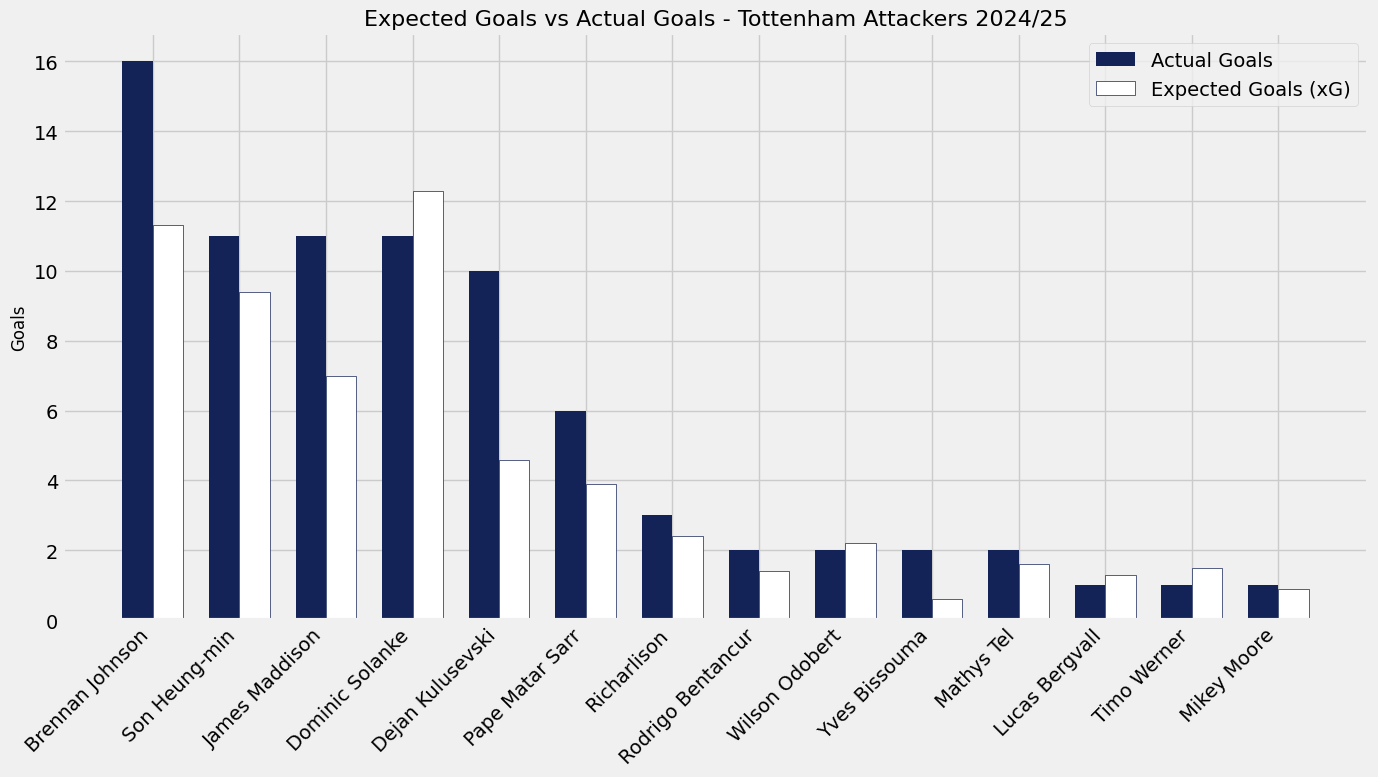

In [13]:
plt.figure(figsize=(14, 8))
players = attacking_players.sort_values('Gls', ascending=False)['Player']
xg = attacking_players.sort_values('Gls', ascending=False)['xG']
goals = attacking_players.sort_values('Gls', ascending=False)['Gls']

x = range(len(players))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(x, goals, width, label='Actual Goals', color='#132257')
ax.bar([i + width for i in x], xg, width, label='Expected Goals (xG)', color='#ffffff', edgecolor='#132257')

ax.set_ylabel('Goals', fontsize=12)
ax.set_title('Expected Goals vs Actual Goals - Tottenham Attackers 2024/25', fontsize=16)
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(players, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# 3. Attacking Radar Chart for Key Players

In [14]:
key_attackers = attacking_players[attacking_players['90s'] >= 20].sort_values('Gls', ascending=False).head(5)

metrics = ['Gls_per90', 'Ast_per90', 'xG_per90', 'xA_per90', 'Shot_conversion', 'KP']

key_attackers[metrics] = key_attackers[metrics].apply(pd.to_numeric, errors='coerce')

key_attackers = key_attackers.dropna(subset=metrics)

scaler = StandardScaler()
key_attackers_scaled = pd.DataFrame(
    scaler.fit_transform(key_attackers[metrics]),
    columns=metrics,
    index=key_attackers['Player']
)

fig = go.Figure()

for player in key_attackers_scaled.index:
    values = key_attackers_scaled.loc[player].tolist()
    values.append(values[0])  

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=metrics + [metrics[0]],
        fill='toself',
        name=player
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[-2, 3]  
        )
    ),
    title='Key Attacking Players Comparison - Standardized Metrics',
    showlegend=True
)

fig.show()

# 4. Shot Locations and Conversion Analysis


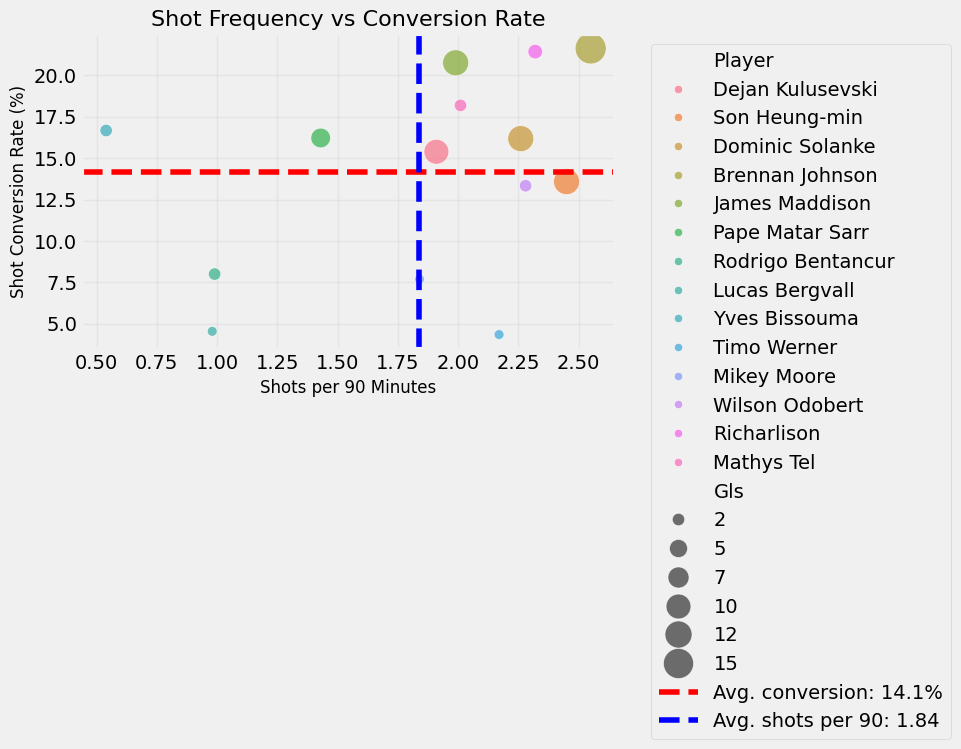

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=attacking_players, 
    x='Sh/90', 
    y='Shot_conversion',
    size='Gls',
    sizes=(50, 500),
    alpha=0.7,
    hue='Player'
)

plt.axhline(y=attacking_players['Shot_conversion'].mean(), color='r', linestyle='--', 
            label=f'Avg. conversion: {attacking_players["Shot_conversion"].mean():.1f}%')
plt.axvline(x=attacking_players['Sh/90'].mean(), color='b', linestyle='--',
            label=f'Avg. shots per 90: {attacking_players["Sh/90"].mean():.2f}')

plt.title('Shot Frequency vs Conversion Rate', fontsize=16)
plt.xlabel('Shots per 90 Minutes', fontsize=12)
plt.ylabel('Shot Conversion Rate (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. xG Overperformance Analysis

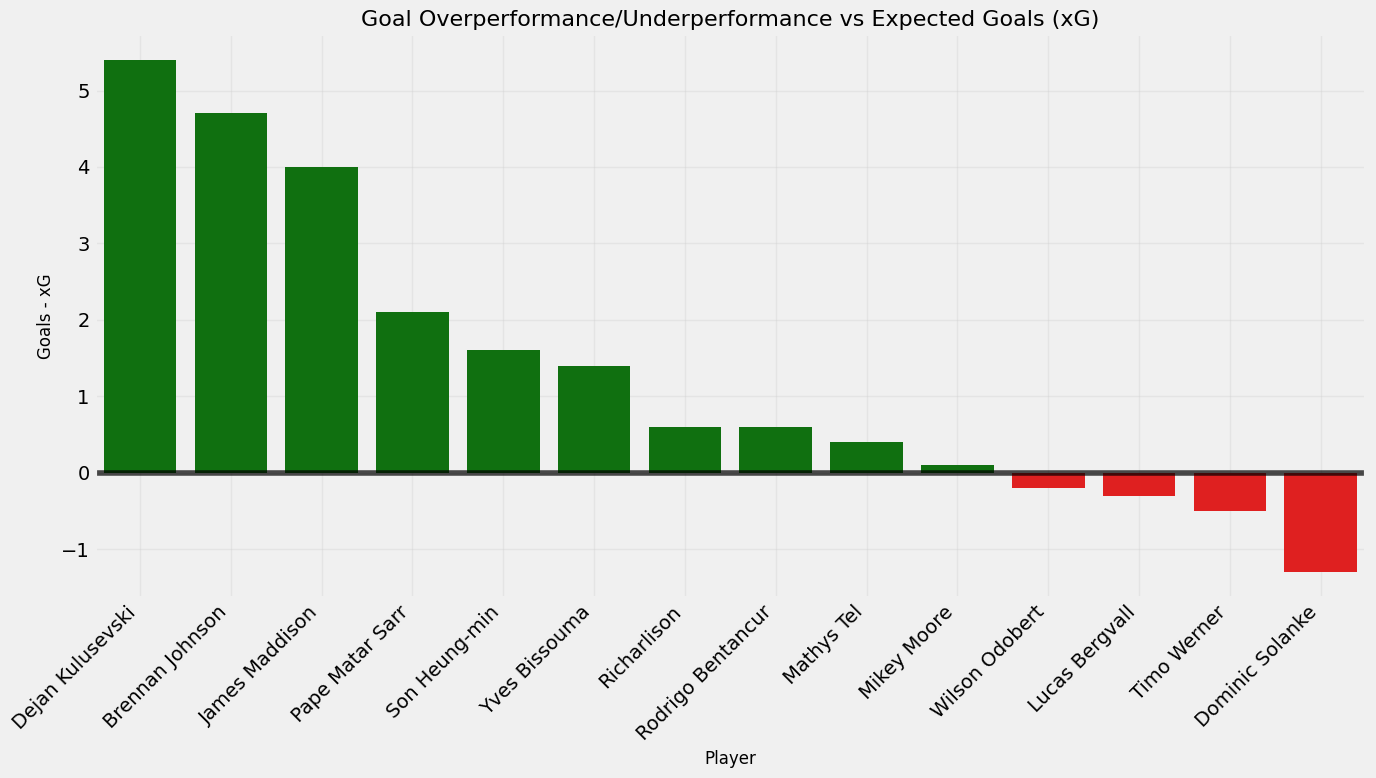

In [16]:
attacking_players_sorted = attacking_players.sort_values('xG_overperformance', ascending=False).copy()
attacking_players_sorted['xG_perf_type'] = attacking_players_sorted['xG_overperformance'].apply(lambda x: 'Overperformer' if x > 0 else 'Underperformer')

plt.figure(figsize=(14, 8))
sns.barplot(
    x='Player',
    y='xG_overperformance',
    data=attacking_players_sorted,
    hue='xG_perf_type',
    palette={'Overperformer': 'green', 'Underperformer': 'red'},
    dodge=False, 
    legend=False 
)

plt.title('Goal Overperformance/Underperformance vs Expected Goals (xG)', fontsize=16)
plt.xlabel('Player', fontsize=12)
plt.ylabel('Goals - xG', fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Creative Contributions Analysis

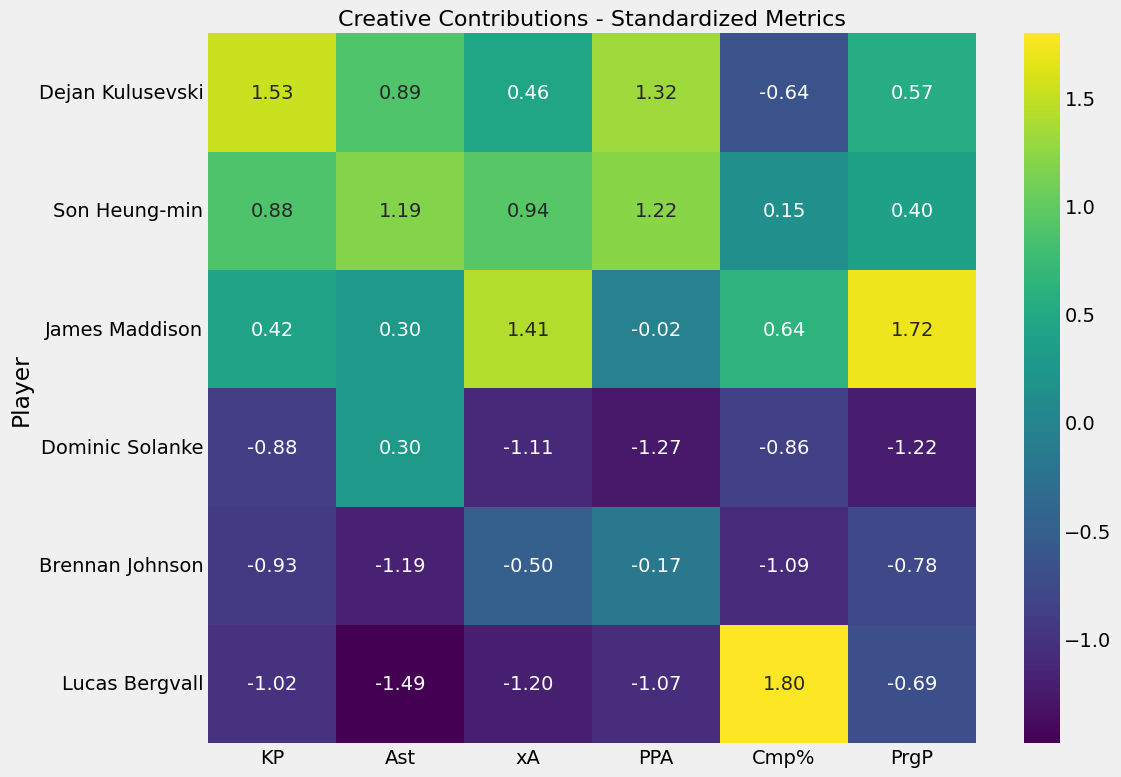

In [17]:
creative_metrics = ['KP', 'Ast', 'xA', 'PPA', 'Cmp%', 'PrgP']
creative_players = attacking_players.sort_values('KP', ascending=False).head(6)

scaler = StandardScaler()
creative_data_scaled = pd.DataFrame(
    scaler.fit_transform(creative_players[creative_metrics]),
    columns=creative_metrics,
    index=creative_players['Player']
)

plt.figure(figsize=(12, 8))
sns.heatmap(creative_data_scaled, annot=True, cmap='viridis', fmt='.2f')
plt.title('Creative Contributions - Standardized Metrics', fontsize=16)
plt.tight_layout()
plt.show()

# 7. Create an Efficiency Index


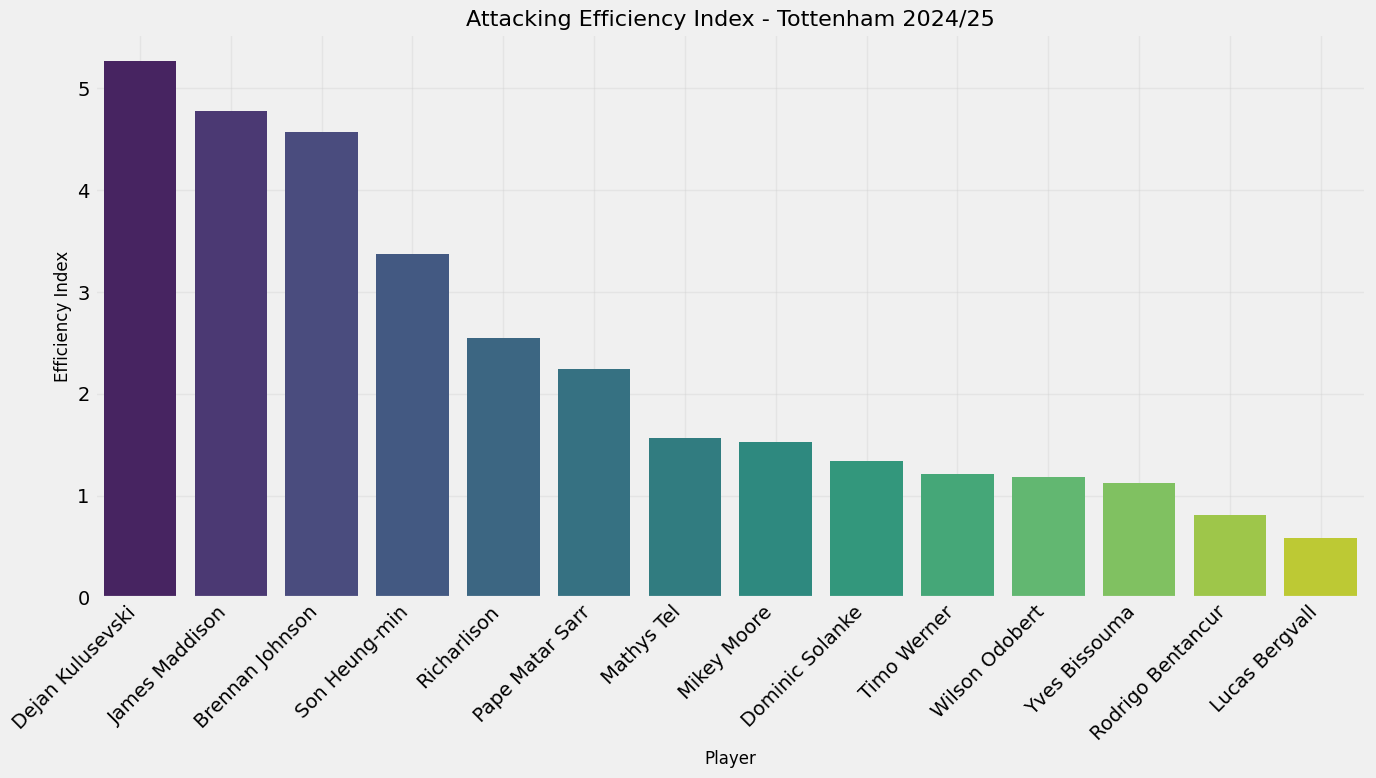

In [18]:
attacking_players['Efficiency_Index'] = (
    attacking_players['Gls_per90'] * 3 + 
    attacking_players['Ast_per90'] * 2 + 
    attacking_players['xG_overperformance'] * 0.5 + 
    attacking_players['KP'] / attacking_players['90s'] * 0.5
)

sorted_efficiency = attacking_players.sort_values('Efficiency_Index', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(
    x='Player',
    y='Efficiency_Index',
    hue='Player',  
    data=sorted_efficiency,
    palette='viridis',
    dodge=False,
    legend=False  
)

plt.title('Attacking Efficiency Index - Tottenham 2024/25', fontsize=16)
plt.xlabel('Player', fontsize=12)
plt.ylabel('Efficiency Index', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8. Create Interactive Dashboard Summary with Plotly

In [19]:
top_players = attacking_players.sort_values('90s', ascending=False).head(8)

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "bar"}, {"type": "scatter"}],
           [{"type": "polar"}, {"type": "scatter"}]],  
    subplot_titles=("Goal Contributions", "Shot Efficiency", 
                    "Player Radar", "Progressive Actions"),  
    horizontal_spacing=0.15,
    vertical_spacing=0.15
)

# 1. Goal Contributions
fig.add_trace(
    go.Bar(x=top_players['Player'], y=top_players['Gls'], name='Goals',
           marker_color='blue'),
    row=1, col=1
)
fig.add_trace(
    go.Bar(x=top_players['Player'], y=top_players['Ast'], name='Assists',
           marker_color='red'),
    row=1, col=1
)

# 2. Shot Efficiency
fig.add_trace(
    go.Scatter(
        x=top_players['Sh/90'], y=top_players['G/Sh'] * 100,
        mode='markers+text', text=top_players['Player'],
        textposition="top center", name='Shot Conversion',
        marker=dict(
            size=top_players['Gls'] * 3,
            color=top_players['xG_overperformance'],
            colorscale='RdBu', showscale=True,
            colorbar=dict(
                title="xG Over/Under",
                x=1.02,
                y=0.75,
                len=0.4,
                yanchor="middle"
            )
        )
    ),
    row=1, col=2
)

# 3. Player Radar chart (polar)
categories = ['Gls', 'Ast', 'KP', 'xG', 'Succ', 'Sh']
values = top_players.iloc[0][categories].tolist()
values += values[:1]

fig.add_trace(
    go.Scatterpolar(
        r=values,
        theta=categories + [categories[0]],
        fill='toself',
        name=top_players.iloc[0]['Player']
    ),
    row=2, col=1
)

# 4. Progressive Actions
fig.add_trace(
    go.Scatter(
        x=top_players['PrgP'], y=top_players['PrgC'],
        mode='markers+text', text=top_players['Player'],
        textposition="top center", name='Progressive Actions',
        marker=dict(
            size=top_players['90s'] * 2,
            color=top_players['Age'],
            colorscale='Viridis', showscale=True,
            colorbar=dict(
                title="Age",
                x=1.02,
                y=0.25,
                len=0.4,
                yanchor="middle"
            )
        )
    ),
    row=2, col=2
)

fig.update_xaxes(title_text="Player", row=1, col=1)
fig.update_xaxes(title_text="Shots per 90", row=1, col=2)
fig.update_xaxes(title_text="Progressive Passes", row=2, col=2)

fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Goal Conversion %", row=1, col=2)
fig.update_yaxes(title_text="Progressive Carries", row=2, col=2) 

fig.update_layout(
    height=1000,
    width=1200,
    title_text="Tottenham Attackers Dashboard 2024/25",
    title_x=0.5,
    barmode='group',
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.15,
        xanchor="center",
        x=0.5
    ),
    margin=dict(t=100, b=100, l=80, r=120)
)

fig.update_traces(hovertemplate='%{y:.1f}', row=1, col=1)
fig.update_traces(hovertemplate='<b>%{text}</b><br>Shots per 90: %{x:.2f}<br>Conversion: %{y:.1f}%', row=1, col=2)
fig.update_traces(hovertemplate='<b>%{text}</b><br>Progressive Passes: %{x}<br>Progressive Carries: %{y}', row=2, col=2) 

fig.update_traces(
    hovertemplate='%{theta}: %{r}<extra></extra>',
    row=2, col=1
)

fig.show()